In [9]:
import os
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


cuda = True if torch.cuda.is_available() else False


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
n_epochs = 200
lr = 2e-4
b1 = .5
b2 = .999
n_cpu = 8
latent_dim = 2
sample_interval = 400

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 100, normalize=False),
            *block(100, 10, normalize=False),
            nn.Linear(10, latent_dim)
        )

    def forward(self, z):
        x = self.model(z)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 20),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(20, 20),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(20, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        validity = self.model(x)

        return validity

In [32]:
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [33]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

In [34]:
# Optimizers

optimizer_G = torch.optim.Adam(generator.parameters(), lr=.01)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=.01)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


In [35]:
%%time
# ----------
#  Training
# ----------

winnings = []
for epoch in range(10):
    # ------------------
    # generate sample game
    # ------------------
    num_games = 100
    X = torch.randn(num_games,2).to(device)
    generated = generator(X).to(device)
    choices = np.random.binomial(n = 1, size = generated.size()[0], p = .5)
    generated_selected = []
    generated_not_selected = []
    for i in range(len(choices)):
        generated_selected.append(generated[i,choices[i]].squeeze())
        generated_not_selected.append(generated[i,~choices[i]].squeeze())

    generated_selected = torch.stack(generated_selected)
    generated_not_selected = torch.stack(generated_not_selected)
    
    guesses = discriminator(generated_selected.view(-1,1))
    
    other_number_is_bigger = (generated_selected < generated_not_selected).to(device, dtype=torch.float32)
    
    winnings.append(torch.sum((guesses>.5).to(device, dtype=torch.float32).squeeze() == 
                               other_number_is_bigger.squeeze()).item())
    
    tricked = (generated_selected >= generated_not_selected).to(device, dtype=torch.float32)
    
    
    
    # --------------- 
    # Train Generator
    # ---------------
    for k in range(1):
        optimizer_G.zero_grad()
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(generated_selected.view(-1,1)), tricked)


        g_loss.backward(retain_graph=True)
        optimizer_G.step()
        
    for k in range(100):
        #print(k)
        # ------------------- 
        # Train Discriminator
        # -------------------
        optimizer_D.zero_grad()
        d_loss = adversarial_loss(discriminator(generated_selected.view(-1,1)), other_number_is_bigger)

        d_loss.backward(retain_graph=True)
        optimizer_D.step()


    
    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % 
           (epoch, n_epochs, i, 100, 
            d_loss.item(), g_loss.item()))
    


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[Epoch 0/200] [Batch 99/100] [D loss: 0.000577] [G loss: 0.695887]
[Epoch 1/200] [Batch 99/100] [D loss: 0.000002] [G loss: 16.276863]
[Epoch 2/200] [Batch 99/100] [D loss: 0.000081] [G loss: 12.988582]
[Epoch 3/200] [Batch 99/100] [D loss: 0.011360] [G loss: 11.953946]
[Epoch 4/200] [Batch 99/100] [D loss: 0.536342] [G loss: 11.083901]
[Epoch 5/200] [Batch 99/100] [D loss: 0.553526] [G loss: 1.464253]
[Epoch 6/200] [Batch 99/100] [D loss: 0.450019] [G loss: 1.799241]
[Epoch 7/200] [Batch 99/100] [D loss: 0.441022] [G loss: 2.559006]
[Epoch 8/200] [Batch 99/100] [D loss: 0.429129] [G loss: 2.672136]
[Epoch 9/200] [Batch 99/100] [D loss: 0.464732] [G loss: 2.136586]
CPU times: user 2.26 s, sys: 25.2 ms, total: 2.29 s
Wall time: 2.29 s


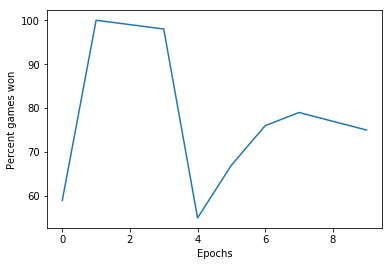

In [36]:
plt.plot(100*np.array(winnings)/num_games)
plt.xlabel("Epochs")
plt.ylabel("Percent games won");

In [37]:
X = torch.randn(1000,2).to(device)
generated = generator(X)
choices = np.random.binomial(n = 1, size = generated.size()[0], p = .5)
generated_selected = []
generated_not_selected = []
for i in range(len(choices)):
    generated_selected.append(generated[i,choices[i]].squeeze())
    generated_not_selected.append(generated[i,~choices[i]].squeeze())

generated_selected = torch.stack(generated_selected)
generated_not_selected = torch.stack(generated_not_selected)

other_number_is_bigger = (generated_selected < generated_not_selected).to(device, dtype=torch.float32)
tricked = (generated_selected >= generated_not_selected).to(device, dtype=torch.float32)

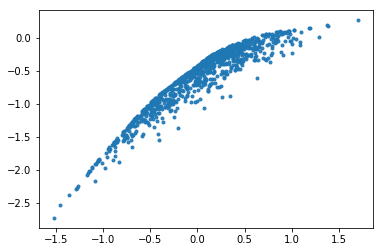

In [38]:
plt.plot(generated[:,0].cpu().detach().numpy(), generated[:,1].cpu().detach().numpy(), '.', alpha = .9)

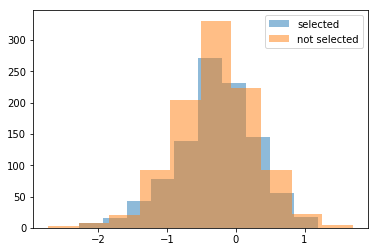

In [39]:
plt.hist(generated_selected.cpu().detach().numpy(), label = "selected", alpha = .5);
plt.hist(generated_not_selected.cpu().detach().numpy(), label = "not selected", alpha = .5);
plt.legend();

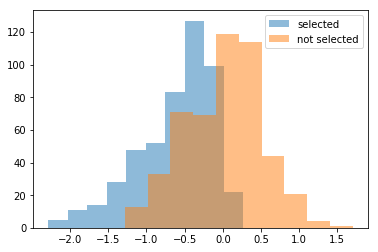

In [40]:

plt.hist(generated_selected.cpu().detach().numpy()[np.where(other_number_is_bigger.cpu().detach().numpy())[0]], label = "selected", alpha = .5);
plt.hist(generated_not_selected.cpu().detach().numpy()[np.where(other_number_is_bigger.cpu().detach().numpy())[0]], label = "not selected", alpha = .5);
plt.legend();

In [23]:
len(generated_selected.detach().numpy()[np.where(other_number_is_bigger.detach().numpy())[0]])

503

In [24]:
len(generated_not_selected.detach().numpy()[np.where(other_number_is_bigger.detach().numpy())[0]])

503

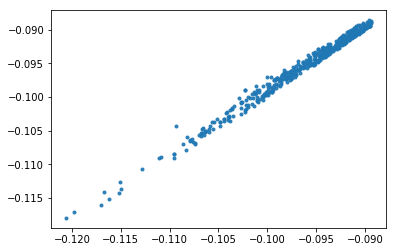

In [25]:
plt.plot(generated_selected.cpu().detach().numpy()[np.where(other_number_is_bigger.cpu().detach().numpy())[0]], 
         generated_not_selected.cpu().detach().numpy()[np.where(other_number_is_bigger.cpu().detach().numpy())[0]], '.', alpha = .9)

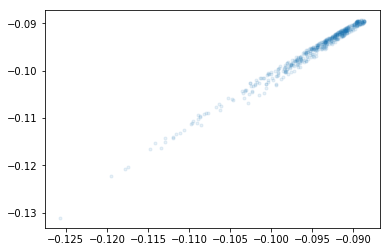

In [26]:
plt.plot(generated_selected.detach().numpy()[np.where(tricked.detach().numpy())[0]], 
         generated_not_selected.detach().numpy()[np.where(tricked.detach().numpy())[0]], '.', alpha = .1)

In [ ]:
generated_selected = torch.stack(generated_selected)
generated_not_selected = torch.stack(generated_not_selected)

other_number_is_bigger = (generated_selected < generated_not_selected).to(device, dtype=torch.float32)
tricked = (generated_selected >= generated_not_selected).to(device, dtype=torch.float32)

In [23]:
X = generated_selected.detach().numpy()
y = other_number_is_bigger.detach().numpy()

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

In [36]:
clf.fit(X[:100, np.newaxis], y[:100])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [37]:
y_preds = clf.predict(X[100:, np.newaxis])
np.mean(y_preds == y[100:])

0.49666666666666665

In [38]:
generated

tensor([[-0.3629, -0.3593],
        [-0.4407, -0.4359],
        [-0.4403, -0.4380],
        ...,
        [-0.3781, -0.3723],
        [-0.4348, -0.4321],
        [-0.5893, -0.5827]], grad_fn=<ThAddmmBackward>)